은행과 같은 금융기관의 리테일 금융소비자(개인 고객)에게 가계신용대출(Home Credit Loan)을 할 경우 고객이 대출금을 상환할지 Target 변수 분류 및 대출금액 예측 프로젝트

In [44]:

import pandas as pd
import numpy as np
import missingno as msno
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
HCD = pd.read_csv("/content/drive/MyDrive/application_train.csv", index_col = False)

In [46]:
HCD = pd.DataFrame(HCD)
HCD.iloc[:, 0:30].info()
HCD.iloc[:, 30:60].info()
HCD.iloc[:, 60:122].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  307511 non-null  int64  
 1   TARGET                      307511 non-null  int64  
 2   NAME_CONTRACT_TYPE          307511 non-null  object 
 3   CODE_GENDER                 307511 non-null  object 
 4   FLAG_OWN_CAR                307511 non-null  object 
 5   FLAG_OWN_REALTY             307511 non-null  object 
 6   CNT_CHILDREN                307511 non-null  int64  
 7   AMT_INCOME_TOTAL            307511 non-null  float64
 8   AMT_CREDIT                  307511 non-null  float64
 9   AMT_ANNUITY                 307499 non-null  float64
 10  AMT_GOODS_PRICE             307233 non-null  float64
 11  NAME_TYPE_SUITE             306219 non-null  object 
 12  NAME_INCOME_TYPE            307511 non-null  object 
 13  NAME_EDUCATION

In [47]:
CodeBook = pd.read_csv("/content/drive/MyDrive/HomeCredit_columns_description.csv", index_col = False, encoding = "Latin-1")
'''
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
Past.iloc[:, [6, 15, 23]]
'''

"\npd.set_option('display.max_columns', None)\npd.set_option('display.max_row', None)\nPast.iloc[:, [6, 15, 23]]\n"

In [48]:
Past = pd.read_csv("/content/drive/MyDrive/previous_application.csv", index_col = False)
Past["NAME_CASH_LOAN_PURPOSE"].unique()
Past.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

count    7.743700e+05
mean     6.697402e+03
std      2.092150e+04
min     -9.000000e-01
25%      0.000000e+00
50%      1.638000e+03
75%      7.740000e+03
max      3.060045e+06
Name: AMT_DOWN_PAYMENT, dtype: float64

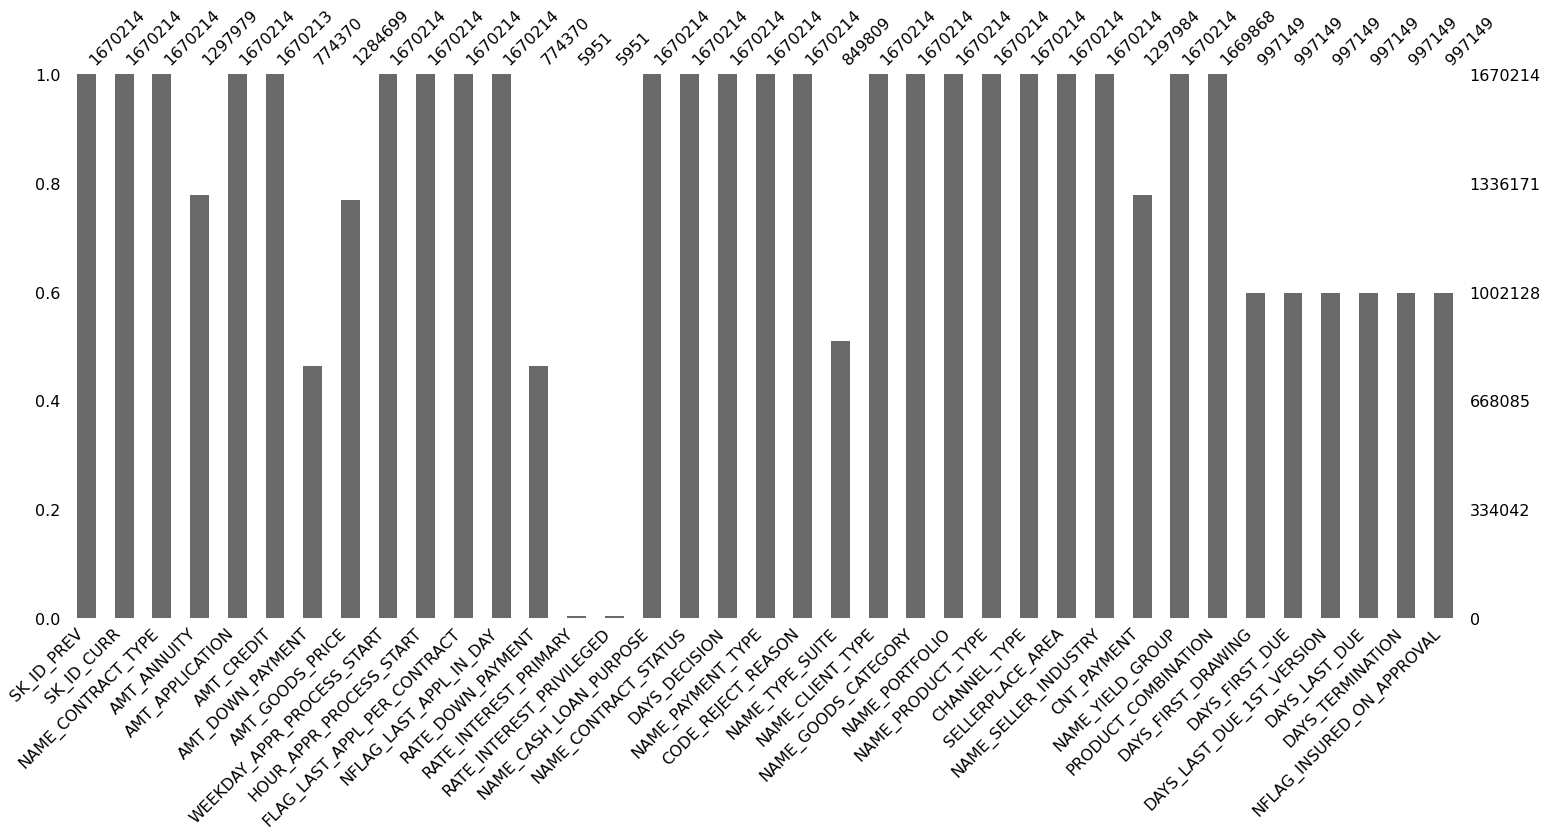

In [49]:
msno.bar(Past)
Past.groupby(["NAME_CASH_LOAN_PURPOSE", "AMT_DOWN_PAYMENT"]).size()
    # [대출목적이 XAP가 아닌 신용대출의 계약금은 모두 0이므로 Down payment > 0인 행 모두 제거]
    # [관측치 삭제] 주택 매매 목적의 신용대출 데이터 제거 이유는 한국의 여신금융상품 체계는 주택담보대출과 신용대출을 구분하고 있기 때문 
Past["AMT_DOWN_PAYMENT"].describe()
    # [Down payment on the previous application]

In [50]:
index = Past[Past["AMT_DOWN_PAYMENT"] != 0].index
Past.drop(index, inplace = True)

In [51]:
Past["AMT_DOWN_PAYMENT"].unique()
    # [대출목적이 XAP가 아닌 신용대출의 계약금은 모두 0이므로 Down payment > 0인 행 모두 제거]

array([0.])

In [52]:
# HCD = HCD.truncate(before = "FLAG_DOCUMENT_21", after = "FLAG_DOCUMENT_2", axis = 1)
    # [ValueError: truncate requires a sorted index]
# HCD.drop(HCD.str.contains("FLAG_DOCUMENT").index, inplace = True)

# [Mutate]
# titanic["adult/child"] = titanic.apply(lambda r: "adult" if r.age >= 20 else "child", axis=1)

  ### HCD 제거목록
    # DAYS_REGISTRATION : 19
    # DAYS_ID_PUBLISH
    # FLAG_MOBIL ~ FLAG_EMAIL  # 제거
    # CMT_FAMILY_MEMBERS
    # REGION_RATING_CLINET
    # WEEKDAY_APPR_PROCESS_START
    # HOUR_APPR_PROCESS_START
    # REG_REGION_NOT_LIVE_REGION ~ LIVE_CITY_NOT_WORK_CITY
    # DAYS_LAST_PHONE_CHANGE
    # FLAG_DOCUMENT_2~21
    # AMT_REQ_CREDIT_BUREAU
    # EXT_SOURCE_1~3   # 제거
    # 건물정보(APARTMENTS_AVG ~ ), 
    * HOUSETYPE_MODE 제외(block of flats : 빌라, terraced house : 단독주택, specific housing : 공공주택)

In [53]:
HCD.drop(HCD.filter(like = "FLAG_DOCUMENT"), axis = 1, inplace = True)
HCD.drop(HCD.filter(like = "EXT_SOURCE"), axis = 1, inplace = True)
col_names = HCD.columns.values

In [54]:
values = pd.DataFrame({
    "column" : col_names,
    "number" : range(0, 99)})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
values

,column,number
0,SK_ID_CURR,0
1,TARGET,1
2,NAME_CONTRACT_TYPE,2
3,CODE_GENDER,3
4,FLAG_OWN_CAR,4
5,FLAG_OWN_REALTY,5
6,CNT_CHILDREN,6
7,AMT_INCOME_TOTAL,7
8,AMT_CREDIT,8
9,AMT_ANNUITY,9


In [55]:
HCD["OBS_30_CNT_SOCIAL_CIRCLE"].head()
HCD["REG_REGION_NOT_LIVE_REGION"].unique()
HCD["REGION_RATING_CLIENT_W_CITY"].unique()
HCD['FLAG_OWN_REALTY'].unique()

array(['Y', 'N'], dtype=object)

In [56]:
HCD.columns.get_loc("DAYS_REGISTRATION")

19

In [57]:
list = []
for i in range(0, 19, 1):
  list.append(i)
for i in [21, 28, 31, 40, 84]:
  list.append(i)
for i in range(88, 92, 1):
  list.append(i)
print(list, end = " ")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 28, 31, 40, 84, 88, 89, 90, 91] 

In [58]:
HCD = HCD.iloc[ : , list]
    # [index location]

In [59]:
HCD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

In [60]:
    # [PANDAS] get column number from colomn name
    # dataframe.columns.get_loc("<col_name>")

### Past 제거 목록
    # AMT_DOWN_PAYMENT [, 6]
    # WEEKDAY ~ HOUR [, [8,9]]
    # FLAG_LAST_APPL ~ [, [10,11]]NFLAG_LAST_APPL_IN_DAT
    # RATE_DOWN_PAYMENT [, 12]
    # DAYS_DESCION [, 17]
    # NAME_TYPE_SUITE [, 20]
    # NAME_PORTFOLIO [, 23]
    # CHANNEL_TYPE [, 25]
    # NAME_PRODUCT_TYPE (알 수 없음) [, 24]
    # SELLERPLACE_AREA [, 26]
    # CNT_PAYMENT (단위알수없음) [, 28]
    # DAYS~ [, 31:35]
    * NAMED_YEILD_GROUP - 기준금리, 가상금리

In [61]:
# [Error] KeyError: '[6 8 9 10 11 12 17 20 23 24 25 26 28 31 32 33 34 35] not found in axis'
# Past.drop(columns = [6, 8, 9, 10, 11, 12, 17, 20, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35])

col_names = 0
col_names = Past.iloc[:, [6, 8, 9, 10, 11, 12, 17, 20, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35]].columns.values
col_names

array(['AMT_DOWN_PAYMENT', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'DAYS_DECISION',
       'NAME_TYPE_SUITE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'],
      dtype=object)

In [62]:
for i in col_names:
  Past.drop(i, axis = 1, inplace = True)

In [63]:
Past.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369854 entries, 0 to 1670209
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SK_ID_PREV                 369854 non-null  int64  
 1   SK_ID_CURR                 369854 non-null  int64  
 2   NAME_CONTRACT_TYPE         369854 non-null  object 
 3   AMT_ANNUITY                336466 non-null  float64
 4   AMT_APPLICATION            369854 non-null  float64
 5   AMT_CREDIT                 369854 non-null  float64
 6   AMT_GOODS_PRICE            369854 non-null  float64
 7   RATE_INTEREST_PRIMARY      979 non-null     float64
 8   RATE_INTEREST_PRIVILEGED   979 non-null     float64
 9   NAME_CASH_LOAN_PURPOSE     369854 non-null  object 
 10  NAME_CONTRACT_STATUS       369854 non-null  object 
 11  NAME_PAYMENT_TYPE          369854 non-null  object 
 12  CODE_REJECT_REASON         369854 non-null  object 
 13  NAME_CLIENT_TYPE           3

HCD(current application) 및 Past(previous application of home credit loan) 데이터프레임 병합 New Credit Bureau

In [64]:
NCB = pd.merge(
    left = HCD, right = Past,
    how = "left", on = "SK_ID_CURR"
) 

In [65]:
pd.set_option('display.max_row', 6)
pd.set_option('display.max_columns', None)
NCB

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,HOUSETYPE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,NaN,Laborers,2,Business Entity Type 3,block of flats,2.0,2.0,2.0,2.0,1038818.0,Consumer loans,9251.775,179055.0,179055.0,179055.0,NaN,NaN,XAP,Approved,XNA,XAP,New,Vehicles,Auto technology,low_normal,POS other with interest,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,NaN,Core staff,1,School,block of flats,1.0,0.0,1.0,0.0,2636178.0,Consumer loans,64567.665,337500.0,348637.5,337500.0,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Refreshed,Furniture,Furniture,middle,POS industry with interest,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,26.0,Laborers,2,Government,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442559,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,NaN,Laborers,2,Business Entity Type 1,block of flats,0.0,0.0,0.0,0.0,2016407.0,Consumer loans,19065.825,223789.5,247423.5,223789.5,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Repeater,Computers,Consumer electronics,low_normal,POS household with interest,1.0
442560,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,NaN,Laborers,2,Business Entity Type 1,block of flats,0.0,0.0,0.0,0.0,1792910.0,Consumer loans,2296.440,18846.0,21456.0,18846.0,NaN,NaN,XAP,Approved,Cash through the bank,XAP,New,Mobile,Connectivity,high,POS mobile with interest,0.0
442561,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.046220,-16856,-1262,NaN,Laborers,1,Business Entity Type 3,block of flats,0.0,0.0,0.0,0.0,1743609.0,Consumer loans,11090.835,102037.5,112815.0,102037.5,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Refreshed,Furniture,Furniture,middle,POS industry with interest,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 442562 entries, 0 to 442561
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   442562 non-null  int64  
 1   TARGET                       442562 non-null  int64  
 2   NAME_CONTRACT_TYPE_x         442562 non-null  object 
 3   CODE_GENDER                  442562 non-null  object 
 4   FLAG_OWN_CAR                 442562 non-null  object 
 5   FLAG_OWN_REALTY              442562 non-null  object 
 6   CNT_CHILDREN                 442562 non-null  int64  
 7   AMT_INCOME_TOTAL             442562 non-null  float64
 8   AMT_CREDIT_x                 442562 non-null  float64
 9   AMT_ANNUITY_x                442548 non-null  float64
 10  AMT_GOODS_PRICE_x            442153 non-null  float64
 11  NAME_TYPE_SUITE              440939 non-null  object 
 12  NAME_INCOME_TYPE             442562 non-null  object 
 13 

'\n[Error]\nNCB = NCB.astype(\n    {"Target":"category", "NAME_CONTRACT_TYPE_x":"category", "CODE_GENDER":"category", \n     "FLAG_OWN_CAR":"category", "FLAG_OWN_REALTY":"category", \n     "NAME_TYPE_SUITE":"category", "NAME_INCOME_TYPE":"category", "NAME_EDUCATION_TYPE":"category", "NAME_FAMILY_STATUS":"category", "NAME_HOUSING_TYPE":"category",\n     "OCCUPATION_TYPE":"category", \n     "NAME_CONTRACT_TYPE_y":"category", "NAME_CASH_LOAN_PURPOSE":"category", "NAME_CONTRACT_STATUS":"category", " NAME_PAYMENT_TYPE":"category", "CODE_REJECT_REASON":"category",\n     "NAME_CLIENT_TYPE":"category", "NAME_GOODS_CATEGORY":"category", "NAME_SELLER_INDUSTRY":"category", "NAME_YIELD_GROUP":"category", "PRODUCT_COMBINATION":"category"})\n'

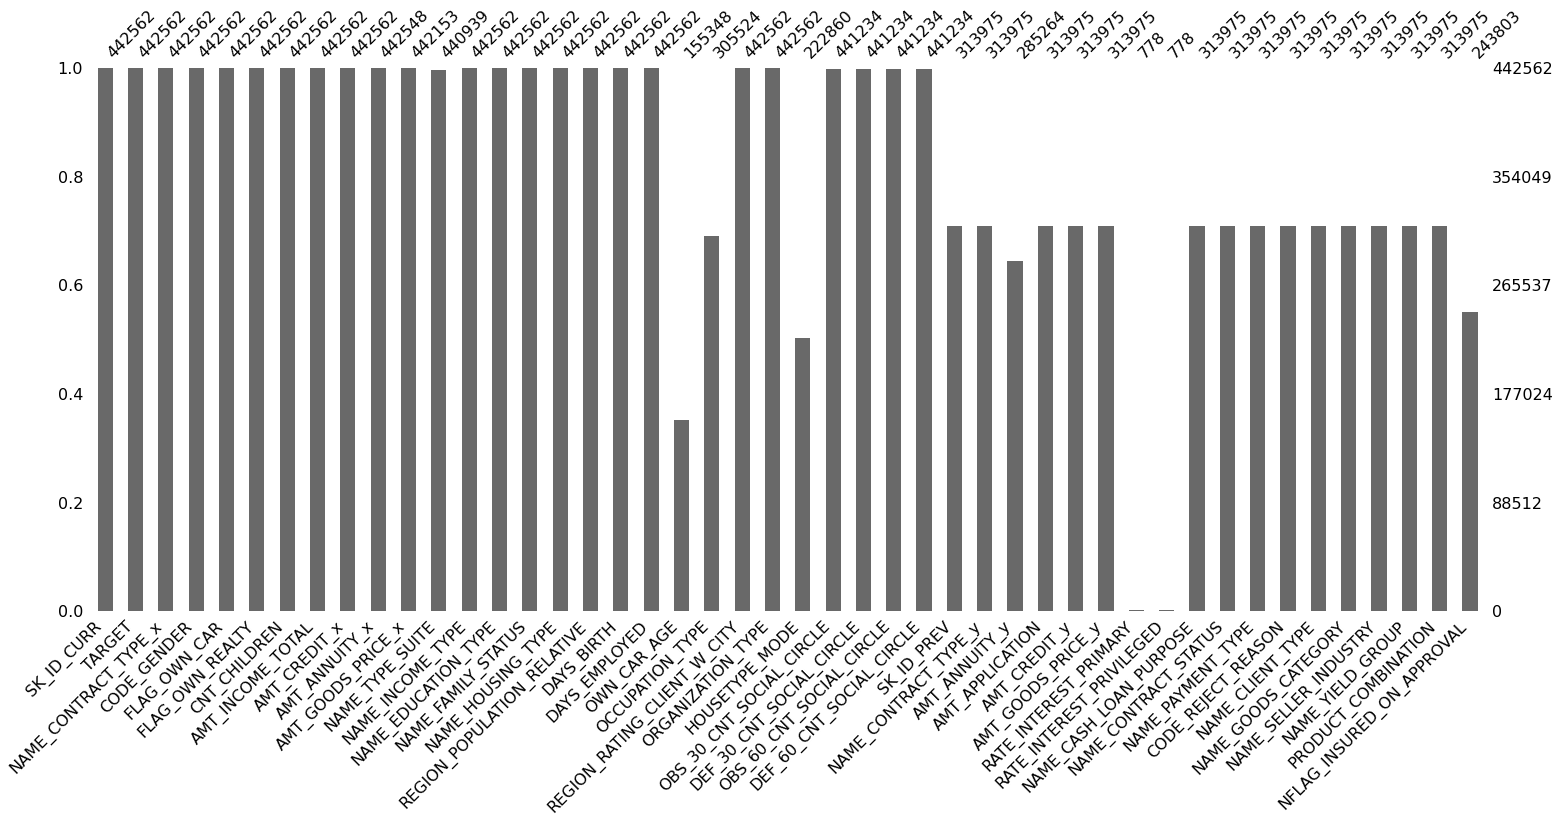

In [74]:
NCB.info()
    # [307511 * 47]이 아닌 [442562 * 47]인 이유
msno.bar(NCB)
'''
[Error]
NCB = NCB.astype(
    {"Target":"category", "NAME_CONTRACT_TYPE_x":"category", "CODE_GENDER":"category", 
     "FLAG_OWN_CAR":"category", "FLAG_OWN_REALTY":"category", 
     "NAME_TYPE_SUITE":"category", "NAME_INCOME_TYPE":"category", "NAME_EDUCATION_TYPE":"category", "NAME_FAMILY_STATUS":"category", "NAME_HOUSING_TYPE":"category",
     "OCCUPATION_TYPE":"category", 
     "NAME_CONTRACT_TYPE_y":"category", "NAME_CASH_LOAN_PURPOSE":"category", "NAME_CONTRACT_STATUS":"category", " NAME_PAYMENT_TYPE":"category", "CODE_REJECT_REASON":"category",
     "NAME_CLIENT_TYPE":"category", "NAME_GOODS_CATEGORY":"category", "NAME_SELLER_INDUSTRY":"category", "NAME_YIELD_GROUP":"category", "PRODUCT_COMBINATION":"category"})
'''

In [75]:
NCB.sort_values(by = ["SK_ID_CURR"], ascending = True)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,HOUSETYPE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,NaN,Laborers,2,Business Entity Type 3,block of flats,2.0,2.0,2.0,2.0,1038818.0,Consumer loans,9251.775,179055.0,179055.0,179055.0,NaN,NaN,XAP,Approved,XNA,XAP,New,Vehicles,Auto technology,low_normal,POS other with interest,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,NaN,Core staff,1,School,block of flats,1.0,0.0,1.0,0.0,2636178.0,Consumer loans,64567.665,337500.0,348637.5,337500.0,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Refreshed,Furniture,Furniture,middle,POS industry with interest,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,26.0,Laborers,2,Government,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442560,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,NaN,Laborers,2,Business Entity Type 1,block of flats,0.0,0.0,0.0,0.0,1792910.0,Consumer loans,2296.440,18846.0,21456.0,18846.0,NaN,NaN,XAP,Approved,Cash through the bank,XAP,New,Mobile,Connectivity,high,POS mobile with interest,0.0
442559,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,NaN,Laborers,2,Business Entity Type 1,block of flats,0.0,0.0,0.0,0.0,2016407.0,Consumer loans,19065.825,223789.5,247423.5,223789.5,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Repeater,Computers,Consumer electronics,low_normal,POS household with interest,1.0
442561,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.046220,-16856,-1262,NaN,Laborers,1,Business Entity Type 3,block of flats,0.0,0.0,0.0,0.0,1743609.0,Consumer loans,11090.835,102037.5,112815.0,102037.5,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Refreshed,Furniture,Furniture,middle,POS industry with interest,0.0


In [76]:
pd.set_option('display.max_row', 10)
NCB["SK_ID_CURR"].duplicated()
    # [과거 신용대출을 중복하여 받은 True 고객이 존재하기 때문]
    # [또는 과거 ID인 SK_ID_PREV가 다르지만 현재 ID인 SK_ID_CURR은 동일한 고객이 존재하기 때문]
NCB["duplicate"] = NCB.duplicated(["SK_ID_CURR"])
NCB[NCB["duplicate"] == True]
    # [135051명]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,HOUSETYPE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL,duplicate
11,100014,0,Cash loans,F,N,Y,1,112500.0,652500.0,21177.0,652500.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.022800,-10197,-679,NaN,Core staff,2,Medicine,NaN,0.0,0.0,0.0,0.0,1461079.0,Consumer loans,11567.475,119272.500,131868.000,119272.500,NaN,NaN,XAP,Approved,Cash through the bank,XAP,New,Computers,Consumer electronics,low_action,POS household without interest,0.0,True
14,100016,0,Cash loans,F,N,Y,0,67500.0,80865.0,5881.5,67500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.031329,-13439,-2717,NaN,Laborers,2,Business Entity Type 2,block of flats,0.0,0.0,0.0,0.0,2824473.0,Consumer loans,7124.040,98500.500,98500.500,98500.500,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Repeater,Computers,Consumer electronics,high,POS household with interest,0.0,True
17,100018,0,Cash loans,F,N,Y,0,189000.0,773680.5,32778.0,679500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010006,-14583,-203,NaN,Laborers,1,Transport: type 2,block of flats,0.0,0.0,0.0,0.0,2704445.0,Consumer loans,94906.035,536364.000,536364.000,536364.000,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Repeater,Construction Materials,Construction,low_normal,POS industry with interest,0.0,True
18,100018,0,Cash loans,F,N,Y,0,189000.0,773680.5,32778.0,679500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010006,-14583,-203,NaN,Laborers,1,Transport: type 2,block of flats,0.0,0.0,0.0,0.0,1251951.0,Consumer loans,4180.365,36805.365,36805.365,36805.365,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Repeater,Mobile,Connectivity,low_normal,POS mobile without interest,0.0,True
21,100020,0,Cash loans,M,N,N,0,108000.0,509602.5,26149.5,387000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018634,-12931,-1317,NaN,Drivers,2,Government,NaN,0.0,0.0,0.0,0.0,1074770.0,Consumer loans,5729.265,32512.500,35086.500,32512.500,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Repeater,Gardening,Consumer electronics,high,POS household with interest,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442547,456244,0,Cash loans,F,N,Y,0,261000.0,1303812.0,35982.0,1138500.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.031329,-20390,-5326,NaN,NaN,2,Business Entity Type 3,block of flats,0.0,0.0,0.0,0.0,1967722.0,Cash loans,17232.030,135000.000,162778.500,135000.000,NaN,NaN,XNA,Refused,Cash through the bank,HC,Repeater,XNA,XNA,middle,Cash X-Sell: middle,NaN,True
442548,456244,0,Cash loans,F,N,Y,0,261000.0,1303812.0,35982.0,1138500.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.031329,-20390,-5326,NaN,NaN,2,Business Entity Type 3,block of flats,0.0,0.0,0.0,0.0,1035930.0,Cash loans,21177.810,180000.000,191880.000,180000.000,NaN,NaN,Other,Approved,Cash through the bank,XAP,New,XNA,XNA,high,Cash Street: high,0.0,True
442552,456247,0,Cash loans,F,N,Y,0,112500.0,345510.0,17770.5,247500.0,Unaccompanied,Commercial associate,Higher education,Si

주성분분석(Principal Component Analysis)으로 변수 선택(차원축소)


In [ ]:
# [Error] TypeError: numpy boolean subtract
# scatter_matrix(NCB, marker = "o", s = 10, alpha = 8, figsize = (12, 8))
# plt.show()